# Imports

In [1]:
!pip install etna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.1/363.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.0/354.0 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from etna.datasets.tsdataset import TSDataset

from etna.models import NaiveModel
from etna.pipeline import Pipeline
from etna.transforms import LinearTrendTransform


from etna.analysis import (
    metric_per_segment_distribution_plot,
    plot_residuals,
    plot_metric_per_segment,
    plot_backtest,
    plot_trend,
    stl_plot,
    plot_anomalies,
    get_anomalies_median,
    prediction_actual_scatter_plot
)

from etna.metrics import(
    MAE,
    MSE,
    SMAPE
)

from IPython.display import clear_output

# Loading data

In [18]:
bitcoin = pd.read_csv('data/Bitcoin_kaggle.csv', sep=';')

That is original dataset. Luckily, other have the same structure

In [19]:
bitcoin.drop(index=bitcoin.index[:7], axis=0, inplace=True)

In [20]:
bitcoin.head()

,Date,Price,Open,High,Low,Vol.,Change %
7,"Jul 07, 2023","30,346.4","29,912.7","30,442.0","29,757.4",46.42K,1.45%
8,"Jul 06, 2023","29,913.1","30,512.8","31,463.6","29,869.0",90.81K,-1.97%
9,"Jul 05, 2023","30,512.8","30,768.6","30,875.6","30,233.3",43.23K,-0.83%
10,"Jul 04, 2023","30,768.4","31,152.0","31,326.5","30,657.8",42.12K,-1.23%
11,"Jul 03, 2023","31,151.3","30,617.5","31,377.0","30,581.5",56.49K,1.74%


# EDA

## Data representation

As we can see, all of columns have Dtype 'object'.

In [21]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 7 to 546
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      540 non-null    object
 1   Price     540 non-null    object
 2   Open      540 non-null    object
 3   High      540 non-null    object
 4   Low       540 non-null    object
 5   Vol.      540 non-null    object
 6   Change %  540 non-null    object
dtypes: object(7)
memory usage: 29.7+ KB


In [22]:
# replace letters in samples
def change_vol(value):
    if 'K' in value:
        value = float(value.replace('K', ''))
        return value * 1000
    elif 'M' in value:
        value = float(value.replace('M', ''))
        return value * 1000000

def clean_dataset(dataset):
    # change to 'datetime'
    dataset['Date'] = pd.to_datetime(dataset['Date'])

    # preparing to float
    for column in ['Price', 'Open', 'High', 'Low']:
        dataset[column] = dataset[column].str.replace(',', '')
        dataset[column] = dataset[column].astype('float64')

    # removing %
    dataset['Change %'] = (dataset['Change %'].str.replace('%', '')).astype('float64')

    # 2k is 2000
    dataset['Vol.'] = dataset['Vol.'].apply(lambda x: change_vol(x))

    return dataset

In [23]:
bitcoin = clean_dataset(bitcoin)

Much better

In [24]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 7 to 546
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      540 non-null    datetime64[ns]
 1   Price     540 non-null    float64       
 2   Open      540 non-null    float64       
 3   High      540 non-null    float64       
 4   Low       540 non-null    float64       
 5   Vol.      524 non-null    float64       
 6   Change %  540 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 29.7 KB


## Feature engeneering

It seems like adding range (differnce between highest and lowest price) will help.

In [25]:
def add_range(dataset):
    dataset['range'] = dataset['High'] - dataset['Low']


add_range(bitcoin)

## Save prepared data

In [30]:
bitcoin.to_csv('data/prepared.csv', index=False)

In [26]:
data = bitcoin

## Plots

Let's use 'ETNA' library from Tinkoff. Here I create dataset for ETNA



In [27]:
data['timestamp'] = data['Date']
data['target'] = data['Price']
data['segment'] = 'main'

data_ts = TSDataset.to_dataset(data)
data_ts = TSDataset(data_ts, freq="D")

In [28]:
data_ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2022-01-14,2023-07-07,540,0,1,8,0,0,D


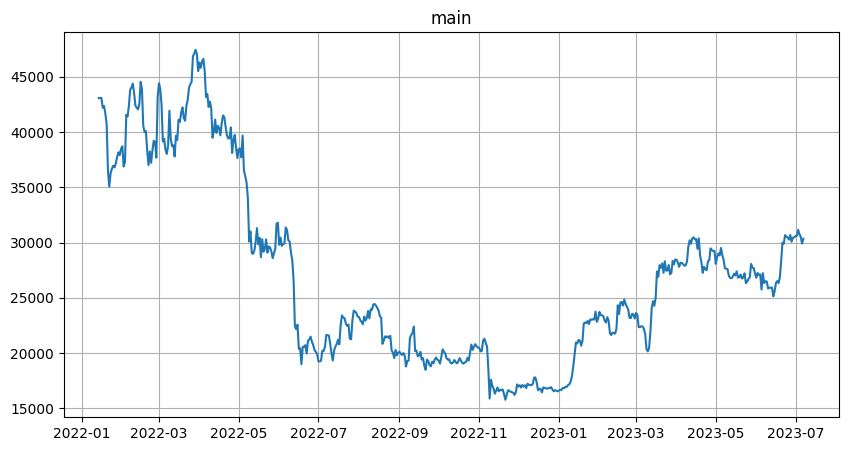

In [29]:
data_ts.plot()

In [ ]:
from etna.transforms import LagTransform
from etna.analysis import (
    cross_corr_plot,
    distribution_plot,
    acf_plot,
    plot_correlation_matrix,
)
from etna.analysis import plot_trend
from etna.transforms import LinearTrendTransform

from etna.analysis import plot_periodogram, stl_plot, seasonal_plot
from etna.analysis import plot_time_series_with_change_points, plot_change_points_interactive
from etna.analysis import find_change_points
from ruptures.detection import Binseg
from etna.analysis.outliers import get_anomalies_median, get_anomalies_density
from etna.analysis import plot_anomalies
from etna.analysis import plot_backtest


In [43]:
trends = [
    LinearTrendTransform(in_column="target", poly_degree=1),
    LinearTrendTransform(in_column="target", poly_degree=2),
]

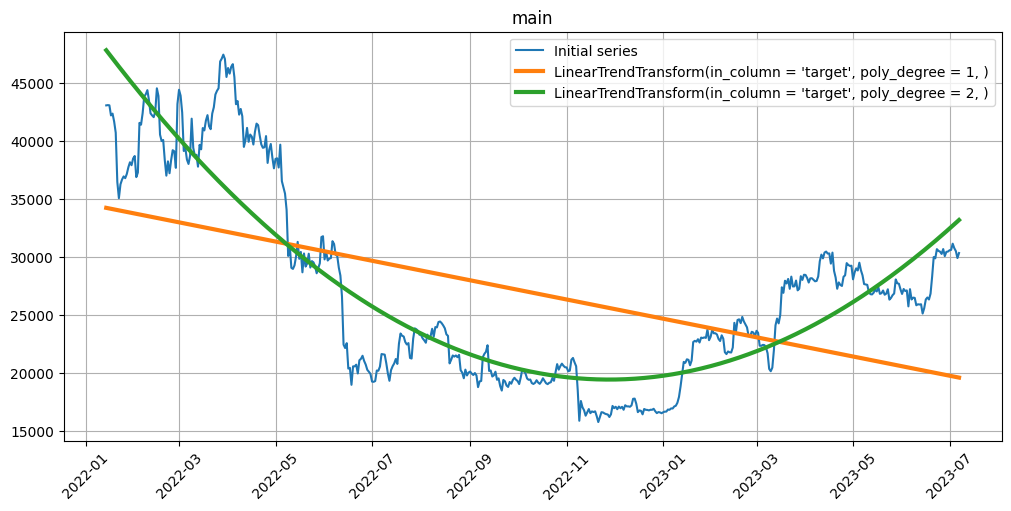

In [46]:
plot_trend(data_ts, trend_transform=trends)

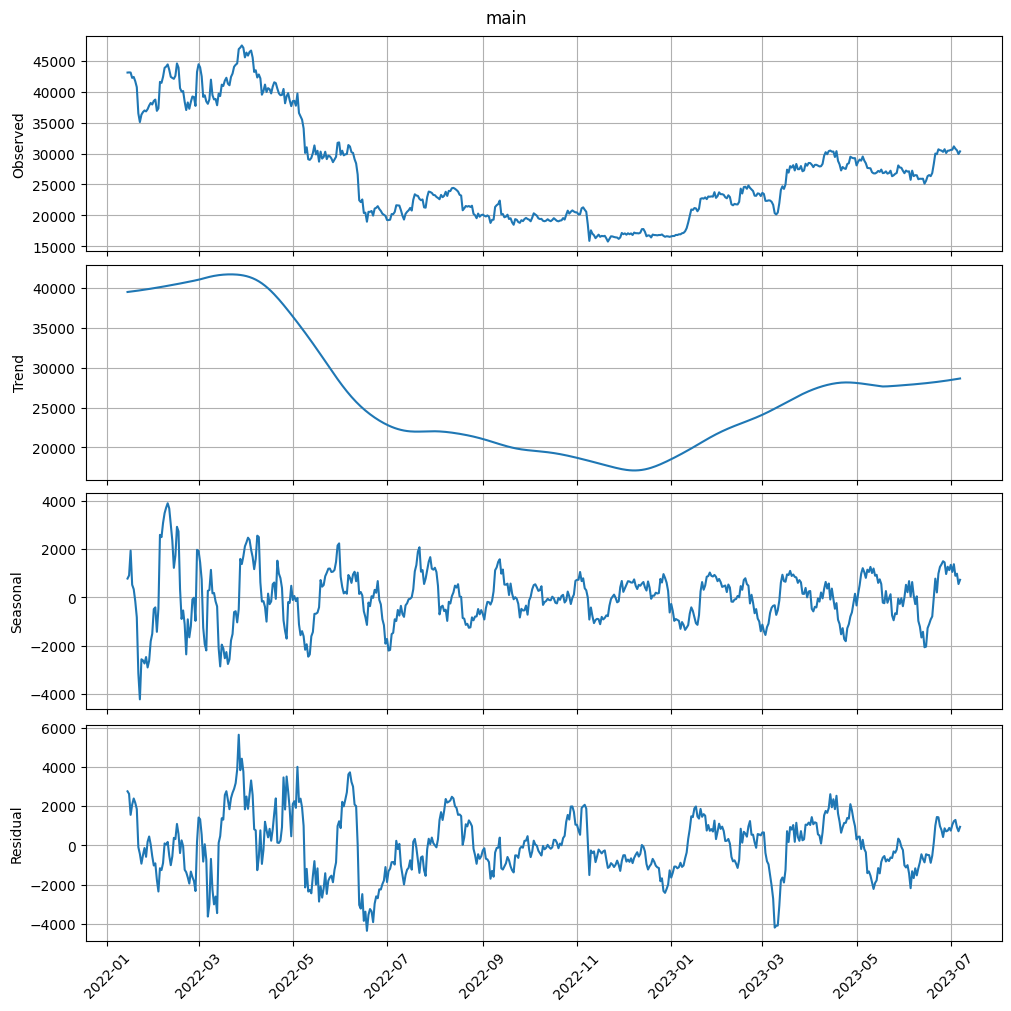

In [50]:
stl_plot(ts=data_ts, period=52)

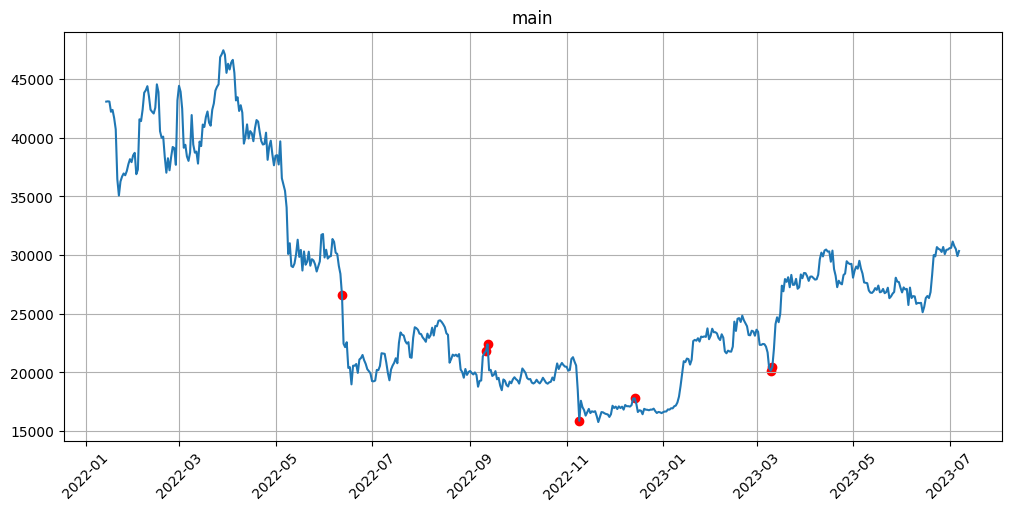

In [53]:
anomaly_dict = get_anomalies_median(data_ts, window_size=30)
plot_anomalies(data_ts, anomaly_dict)

# Traning

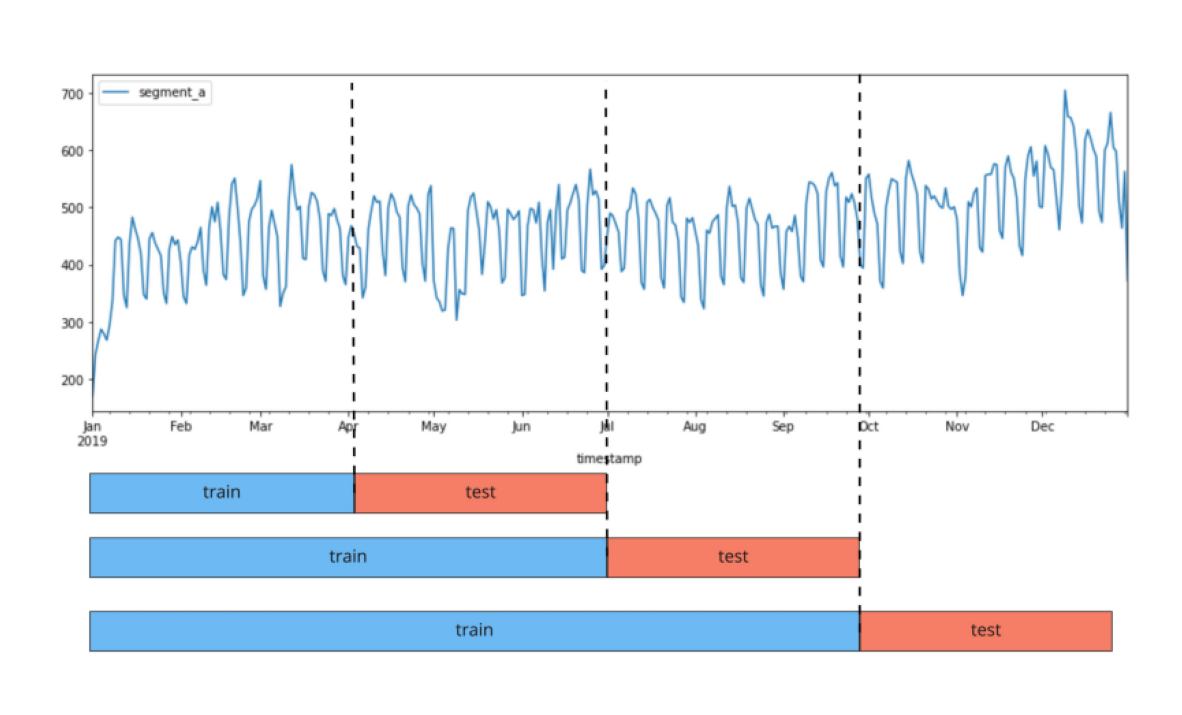

In [32]:
img = plt.imread("backtest.png")
plt.figure(figsize=(15, 10))
plt.axis("off")
_ = plt.imshow(img)

In [33]:
data.drop('Date', axis=1, inplace=True)

In [34]:
data_ts = TSDataset.to_dataset(data)
data_ts = TSDataset(data_ts, freq="D")

In [35]:
data_ts.head()

segment        main                                                       \
feature    Change %     High      Low     Open    Price     Vol.   range   
timestamp                                                                  
2022-01-14     1.21  43435.1  41848.7  42562.2  43073.3  50500.0  1586.4   
2022-01-15     0.06  43777.9  42586.1  43073.6  43097.0  31440.0  1191.8   
2022-01-16    -0.04  43462.0  42643.3  43079.2  43079.1  28660.0   818.7   
2022-01-17    -2.02  43179.6  41559.4  43080.5  42209.3  41440.0  1620.2   
2022-01-18     0.37  42674.2  41300.7  42209.9  42364.6  47320.0  1373.5   

segment              
feature      target  
timestamp            
2022-01-14  43073.3  
2022-01-15  43097.0  
2022-01-16  43079.1  
2022-01-17  42209.3  
2022-01-18  42364.6

## Simple models

In [36]:
model = NaiveModel()
HORIZON = 7


pipeline = Pipeline(model=model,
                    horizon=HORIZON)

In [55]:
metrics_df, forecast_df, fold_info_df = pipeline.backtest(
    ts=data_ts,
    metrics=[MAE(), MSE(), SMAPE()],
    n_folds=5,
)
clear_output()

In [56]:
metrics_df

,segment,MAE,MSE,SMAPE,fold_number
0,main,602.585714,6.056668e+05,2.253449,0
0,main,669.200000,5.666845e+05,2.568442,1
0,main,2027.028571,6.990124e+06,7.224847,2
0,main,260.428571,9.935470e+04,0.854188,3
0,main,279.828571,1.303511e+05,0.916401,4


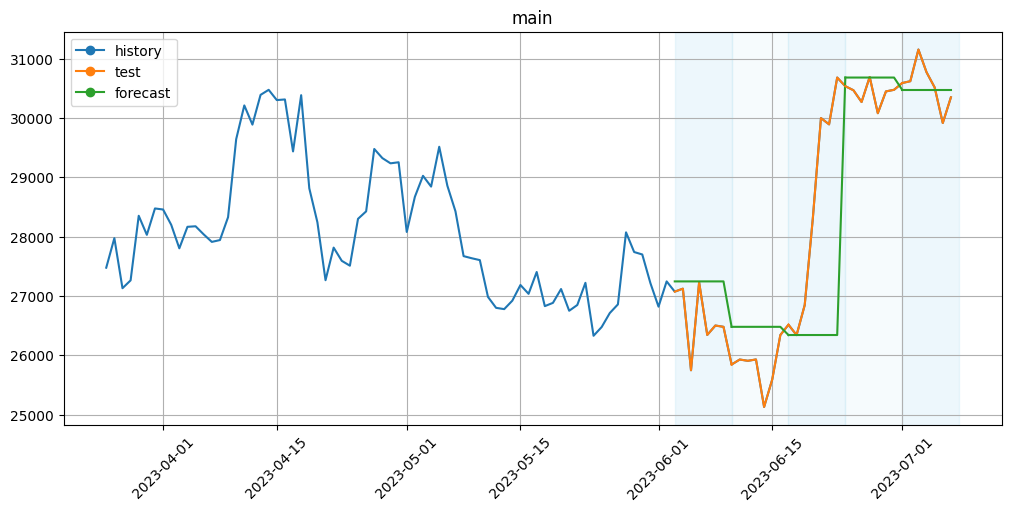

In [57]:
plot_backtest(forecast_df, data_ts, history_len=70)

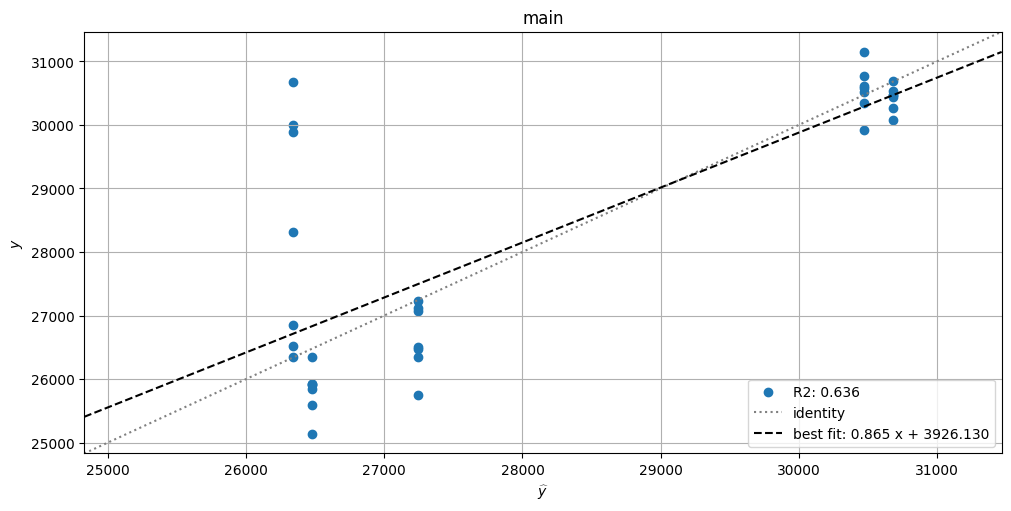

In [59]:
prediction_actual_scatter_plot(forecast_df=forecast_df, ts=data_ts)

In [60]:
pipeline.fit(data_ts)
forecast_ts = pipeline.forecast()

/usr/local/lib/python3.10/dist-packages/etna/models/seasonal_ma.py:64: UserWarning: This model doesn't work with exogenous features. Columns {'Open', 'Price', 'Low', 'range', 'Vol.', 'Change %', 'High'} won't be used.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:279: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(


In [61]:
submit = pd.DataFrame({
    'Date': forecast_ts[:, :, :]['main']['target'].index,
    'Price': forecast_ts[:, :, :]['main']['target'].values
})

In [62]:
submit.to_csv('sub.csv', index=False)